# Entrenamiento modelo para detección de Phising a partir de una URL

Importamos la librerías necesarias para la realización del proyecto

In [2]:
import os
import tempfile
from pyspark.sql import SparkSession

# Detectar automáticamente Java 17 o 11 (PySpark 4.1.0+ requiere Java 17+)
if 'JAVA_HOME' not in os.environ:
    try:
        # Intentar Java 17 primero (requerido para PySpark 4.1.0+)
        java_home_17 = os.popen('/usr/libexec/java_home -v 17 2>/dev/null').read().strip()
        if java_home_17:
            os.environ['JAVA_HOME'] = java_home_17
        else:
            # Si no hay Java 17, intentar Java 11
            java_home_11 = os.popen('/usr/libexec/java_home -v 11 2>/dev/null').read().strip()
            if java_home_11:
                os.environ['JAVA_HOME'] = java_home_11
    except:
        pass

# Path dinámico para warehouse (compatible con cualquier OS)
warehouse_dir = os.path.join(tempfile.gettempdir(), "spark-warehouse")
os.makedirs(warehouse_dir, exist_ok=True)

spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Ejemplo pySparkSQL") \
    .config("spark.driver.host", "127.0.0.1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.sql.warehouse.dir", f"file://{warehouse_dir}") \
    .getOrCreate()

sc = spark.sparkContext

In [3]:
%matplotlib inline 
from pyspark.sql import Row, DataFrame
import matplotlib.pyplot as plt
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from functools import reduce
import matplotlib.pyplot as plt
from pyspark.sql.types import NumericType
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler

from pyspark.ml import *
from pyspark.ml.param import *
from pyspark.ml.tuning import *
from pyspark.ml.feature import *
from pyspark.ml.evaluation import *
from pyspark.ml.classification import *

Guardamos el path del csv

In [4]:
csv_path = os.path.join(os.getcwd(), "phishing_features.csv")
print(f"CSV path: {csv_path}")

CSV path: c:\Users\Ivan1\Desktop\MASTER\Computacion\BigData\Trabajo\URL_phising_detector\phishing_features.csv


Cargamos el csv en un dataframe e imprimimos el schema del mismo

In [5]:
df = spark.read.csv(csv_path, inferSchema=True, header=True)
print("Elementos en DataFrame a partir de datos/personas.csv: " + str(df.count()) + "\nEsquema: ")
print (df.printSchema())
type(df)

Elementos en DataFrame a partir de datos/personas.csv: 160064
Esquema: 
root
 |-- url: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- url_length: integer (nullable = true)
 |-- num_dots: integer (nullable = true)
 |-- has_https: integer (nullable = true)
 |-- has_ip: integer (nullable = true)
 |-- num_subdirs: integer (nullable = true)
 |-- num_params: integer (nullable = true)
 |-- suspicious_words: integer (nullable = true)
 |-- tld: string (nullable = true)
 |-- special_char_count: integer (nullable = true)
 |-- digits_count: integer (nullable = true)
 |-- entropy: double (nullable = true)

None


pyspark.sql.dataframe.DataFrame

Lo primero que vamos a comprobar es si nuestro dataset está desbalanceado o no. Al tener un problema binario, lo ideal sería tener un 50% de ejemplos de cada clase. En el caso de que la diferencia sea muy obvia, tendremos que aplicar ciertas medidas para que no afecte al rendimiento del modelo

In [6]:
count_1 = df.filter(df['label'] == 1).count()
count_0 = df.filter(df['label'] == 0).count()
total = df.count()


perc_0 = (count_0 / total) * 100
perc_1 = (count_1 / total) * 100

print()

print(f"Benign (0): {count_0} records ({perc_0:.2f}%)")
print(f"Phishing (1): {count_1} records ({perc_1:.2f}%)")


Benign (0): 820 records (0.51%)
Phishing (1): 159244 records (99.49%)


Comprobamos que en efecto, nuestro dataset está desbalanceado

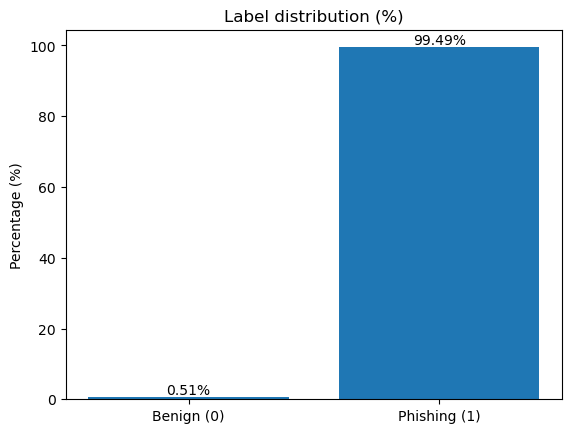

In [7]:
labels = ["Benign (0)", "Phishing (1)"]
percentages = [perc_0, perc_1]

plt.figure()
bars = plt.bar(labels, percentages)
plt.ylabel("Percentage (%)")
plt.title("Label distribution (%)")

# Añadir el texto del porcentaje encima de cada barra
for bar, perc in zip(bars, percentages):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{perc:.2f}%",
        ha="center",
        va="bottom"
    )

plt.show()

Vamos a dejar pasar esto por ahora a ver que tal funciona una regresión logística con estos datos.

A continuación, vamos a buscar si nuestro dataset posee valores nulos. Muchos modelos no aceptan valores nulos en su entrenamiento. Si no los tratamos, probablemente nos salte un error y no podremos continuar hasta que lo solucionemos. Si, por lo que sea, el modelo acepta los valores nulos, estos pueden suponer un problema que afecta al rendimiento del modelo ya que perderemos información que puede ser valiosa en el entrenamiento o podemos caer en sesgos. Buscamos valores nulos en el dataset para tratarlo de forma adecuada.

In [8]:
condition = reduce(
    lambda a, b: a | b,
    [col(c).isNull() for c in df.columns]
)

n = df.filter(condition).count()
df.filter(condition).show(n, truncate=False)

+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|url                     |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld |special_char_count|digits_count|entropy           |
+------------------------+-----+----------+--------+---------+------+-----------+----------+----------------+----+------------------+------------+------------------+
|https://verify-att.app./|1    |24        |2       |1        |0     |3          |0         |1               |NULL|1                 |0           |3.688721875540867 |
|google.com              |0    |10        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |2.6464393446710157|
|youtube.com             |0    |11        |1       |0        |0     |0          |0         |0               |NULL|0                 |0           |3.095795255000934 |
|wik

Vemos que hay varios registros cuyo tld (dominio) es nulo. Vamos a recorrer todas las url cuyo tld sea nulo y vamos a asignarles su correspondiente dominio

In [9]:
df = df.withColumn(
    "tld",
    when(col("tld").isNull(),    
        element_at(split(lit(col("url")), r"\."), -1).alias("tld")
    ).otherwise(col("tld"))
)

df = df.cache()
df.count()

df.filter((col("url") == 'google.com') | (col('url') == 'wikipedia.org') | (col('url') == 'safeexample99.net')).show(truncate=False)

+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|url              |label|url_length|num_dots|has_https|has_ip|num_subdirs|num_params|suspicious_words|tld|special_char_count|digits_count|entropy           |
+-----------------+-----+----------+--------+---------+------+-----------+----------+----------------+---+------------------+------------+------------------+
|google.com       |0    |10        |1       |0        |0     |0          |0         |0               |com|0                 |0           |2.6464393446710157|
|wikipedia.org    |0    |13        |1       |0        |0     |0          |0         |0               |org|0                 |0           |3.334679141051595 |
|safeexample99.net|0    |17        |1       |0        |0     |0          |0         |0               |net|0                 |2           |3.381580488309163 |
+-----------------+-----+----------+--------+-------

Vemos en tres de URL antes filtradas que ya no tienen tld nulo

Vemos cuantos domonios y de cada tipo hay

In [10]:

from pyspark.sql.functions import countDistinct

unique_tlds = df.select("tld").distinct().count()
print(f"Total de TLDs únicos en el dataset: {unique_tlds}")

print("\nTLDs más frecuentes:")
tld_counts = df.groupBy("tld").count().orderBy(col("count").desc())
tld_counts.show(20, truncate=False)

print("\nNOTA: La conversión de TLD a numérico se realizará dentro de la Pipeline")
print("para asegurar que el StringIndexer aprenda solo del conjunto de entrenamiento.")

Total de TLDs únicos en el dataset: 538

TLDs más frecuentes:
+------+-----+
|tld   |count|
+------+-----+
|com   |32706|
|ru    |15011|
|202   |3745 |
|34    |3551 |
|227   |3312 |
|de    |2783 |
|app   |2758 |
|dev   |2691 |
|me    |2549 |
|232   |2262 |
|228   |2262 |
|ly    |2185 |
|to    |2037 |
|page  |1941 |
|199   |1876 |
|info  |1429 |
|online|1328 |
|org   |1286 |
|io    |1203 |
|net   |1190 |
+------+-----+
only showing top 20 rows


NOTA: La conversión de TLD a numérico se realizará dentro de la Pipeline
para asegurar que el StringIndexer aprenda solo del conjunto de entrenamiento.


## Implementación de Modelos

Dividimos nuestros datos en train y test

In [11]:
seed = 12418
train, test_total = df.randomSplit([0.6, 0.4], seed=seed)

train.cache()
test_total.cache()

train_count = train.count() 
test_count_total = test_total.count()

print(f"Train count: {train_count}")
print(f"Test count: {test_count_total}")

Train count: 96487
Test count: 63577


Usando el conjunto de test_total, dividimos en valdidacion y test

In [12]:
val, test = test_total.randomSplit([0.5, 0.5], seed=seed)

val.cache()
test.cache()

val_count = val.count()
test_count = test.count()

print(f"Validation count: {val_count}")
print(f"Test count: {test_count}")


Validation count: 31925
Test count: 31652


Columnas a usar en el entrenamiento

In [60]:
feature_cols = ['url_length', 'num_dots', 'has_https', 'has_ip', 'num_subdirs', 
                'num_params', 'suspicious_words', 'tld_indexed', 'special_char_count', 
                'digits_count', 'entropy']

Entrenamos una Regresión Logística sencilla con Acurracy como métrica de rendimiento para ver que tal funciona

In [14]:
tld_indexer = StringIndexer(
    inputCol="tld",
    outputCol="tld_indexed", 
    handleInvalid="keep"  
)


assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features"
)

logistic_regression = LogisticRegression(
    maxIter=20, 
    regParam=0.01, 
    featuresCol='features', 
    labelCol='label'
)


pipeline = Pipeline(stages=[tld_indexer, assembler, logistic_regression])

print("Pipeline creada con los siguientes stages:")
print("1. StringIndexer (TLD -> numérico)")
print("2. VectorAssembler (features -> vector)")
print("3. LogisticRegression (modelo)")
print("\nEntrenando pipeline...")

pipeline_model = pipeline.fit(train)


tld_indexer_model = pipeline_model.stages[0]  
tld_labels = tld_indexer_model.labels
print("\nMapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):")
print("=" * 60)
for idx, tld in enumerate(tld_labels[:10]):  # Mostrar los primeros 10
    print(f"{tld:25s} -> {idx}")
if len(tld_labels) > 10:
    print(f"... y {len(tld_labels) - 10} TLDs más")
print(f"\nTotal de TLDs únicos aprendidos: {len(tld_labels)}")
print("=" * 60)

print("\nAplicando pipeline a datos de validación...")
prediction = pipeline_model.transform(val)


evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)

accuracy = evaluator.evaluate(prediction)
print(f"\nAccuracy: {accuracy:.4f}")


Pipeline creada con los siguientes stages:
1. StringIndexer (TLD -> numérico)
2. VectorAssembler (features -> vector)
3. LogisticRegression (modelo)

Entrenando pipeline...

Mapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):
com                       -> 0
ru                        -> 1
202                       -> 2
34                        -> 3
227                       -> 4
app                       -> 5
de                        -> 6
dev                       -> 7
me                        -> 8
228                       -> 9
... y 497 TLDs más

Total de TLDs únicos aprendidos: 507

Aplicando pipeline a datos de validación...

Accuracy: 0.9950


Vemos que nos da un accuracy muy bueno, sin embargo, este resultado es engañoso. Vamos a consultar la matriz de confusión para que está ocurriendo

c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


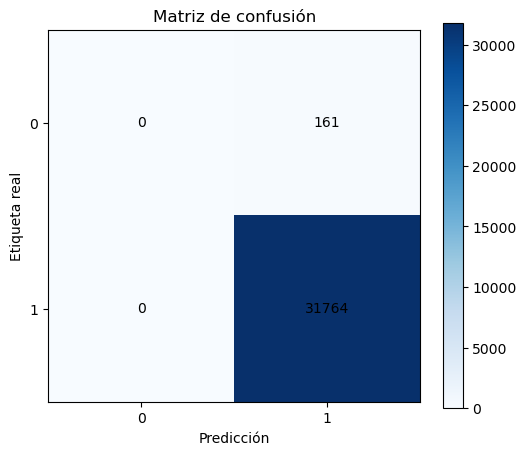

c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall medio (TPR+TNR)/2: 0.5000


In [15]:
def matrizConfusion(prediction):
    rdd = prediction.select("prediction", "label") \
        .rdd.map(lambda r: (float(r["prediction"]), float(r["label"])))

    metrics = MulticlassMetrics(rdd)
    cm = metrics.confusionMatrix().toArray()

    labels = np.unique(prediction.select("label").toPandas())

    plt.figure(figsize=(6,5))
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xticks(range(len(labels)), labels)
    plt.yticks(range(len(labels)), labels)

    plt.xlabel("Predicción")
    plt.ylabel("Etiqueta real")
    plt.title("Matriz de confusión")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, int(cm[i, j]),
                    ha="center", va="center")

    plt.show()

def recall_medio_clases(prediction):
    rdd = prediction.select("prediction", "label") \
        .rdd.map(lambda r: (float(r["prediction"]), float(r["label"])))

    metrics = MulticlassMetrics(rdd)
    cm = metrics.confusionMatrix().toArray()
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]

    TPR = TP / (TP + FN) if (TP + FN) else 0.0   # recall clase 1
    TNR = TN / (TN + FP) if (TN + FP) else 0.0   # recall clase 0

    recall_medio = (TPR + TNR) / 2
    return recall_medio

matrizConfusion(prediction)
recall_medio = recall_medio_clases(prediction)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")

Comprobamos que al ser un problema excesivamente desbalanceado, el accuracy no nos sirve para medir el rendimiento del modelo. En la matriz de confusión vemos que el modelo clasifica todos los registros como clase 1 (phising). Al ser la mayoría ejemplos de clase 1, el accuracy nos sale muy alto. Sin embargo, el modelo no está funcionando bien porque no es capaz de clasificar correctamente un ejemplo que no es phising.

Vamos a tomar ciertas medidas para balancear un poco los ejemplos del problema para ver si el rendimiento del modelo aumenta

### Undersampling

In [16]:
phising_examples = train.filter(col("label") == 1)
non_phising_examples = train.filter(col("label") == 0)

print(f"Train original → phising: {phising_examples.count()}, no phising: {non_phising_examples.count()}")

fraction = non_phising_examples.count() / phising_examples.count()

majority_under = phising_examples.sample(
    withReplacement=False,
    fraction=fraction,
    seed=42
)

train_under = non_phising_examples.unionByName(majority_under)

print("Train balanceado:")
train_under.groupBy("label").count().show()

Train original → phising: 95998, no phising: 489
Train balanceado:
+-----+-----+
|label|count|
+-----+-----+
|    0|  489|
|    1|  502|
+-----+-----+



Volvemods a reentrenar la regresión logística utilizando el conjunto train_under y usando recall-medio por clases como métrica de rendimiento

In [17]:
tld_indexer = StringIndexer(
    inputCol="tld",
    outputCol="tld_indexed", 
    handleInvalid="keep"  
)

assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features"
)

logistic_regression = LogisticRegression(
    maxIter=20, 
    regParam=0.01, 
    featuresCol='features', 
    labelCol='label'
)


pipeline = Pipeline(stages=[tld_indexer, assembler, logistic_regression])

print("Pipeline creada con los siguientes stages:")
print("1. StringIndexer (TLD -> numérico)")
print("2. VectorAssembler (features -> vector)")
print("3. LogisticRegression (modelo)")
print("\nEntrenando pipeline...")


pipeline_model = pipeline.fit(train_under)


tld_indexer_model = pipeline_model.stages[0]  
tld_labels = tld_indexer_model.labels
print("\nMapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):")
print("=" * 60)
for idx, tld in enumerate(tld_labels[:10]):  # Mostrar los primeros 10
    print(f"{tld:25s} -> {idx}")
if len(tld_labels) > 10:
    print(f"... y {len(tld_labels) - 10} TLDs más")
print(f"\nTotal de TLDs únicos aprendidos: {len(tld_labels)}")
print("=" * 60)

print("\nAplicando pipeline a datos de validación...")
prediction = pipeline_model.transform(val)

Pipeline creada con los siguientes stages:
1. StringIndexer (TLD -> numérico)
2. VectorAssembler (features -> vector)
3. LogisticRegression (modelo)

Entrenando pipeline...

Mapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):
com                       -> 0
org                       -> 1
edu                       -> 2
net                       -> 3
ru                        -> 4
34                        -> 5
202                       -> 6
227                       -> 7
228                       -> 8
app                       -> 9
... y 185 TLDs más

Total de TLDs únicos aprendidos: 195

Aplicando pipeline a datos de validación...


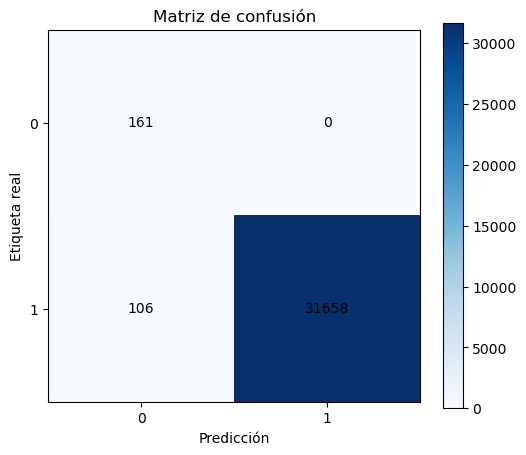

c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall medio (TPR+TNR)/2: 0.9983


In [18]:
matrizConfusion(prediction)
recall_medio = recall_medio_clases(prediction)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")

Podemos observar el recall medio por clases mejora considerablemente (de 0.5 a 0.9983). Vemos que ahora hay 161 ejemplos de la clase no-phising que se están clasificando correctamente, es decir, ya no clasifica todo como clase phising. Todavía hay bastantes falsos negativos pero en general los resultados son bastante satisifactorios aplicando undersampling

### Oversampling

In [19]:
phising_examples = train.filter(col("label") == 1)
non_phising_examples = train.filter(col("label") == 0)

print(f"Train original → phising: {phising_examples.count()}, no phising: {non_phising_examples.count()}")

fraction = phising_examples.count() / non_phising_examples.count()

majority_under = non_phising_examples.sample(
    withReplacement=True,
    fraction=fraction,
    seed=42
)

train_over = phising_examples.unionByName(majority_under)

print("Train balanceado:")
train_over.groupBy("label").count().show()

Train original → phising: 95998, no phising: 489
Train balanceado:
+-----+-----+
|label|count|
+-----+-----+
|    1|95998|
|    0|96392|
+-----+-----+



Entrenamos la regresión logística usando train_over y como recall-medio por clases como métrica de rendimiento

In [20]:
tld_indexer = StringIndexer(
    inputCol="tld",
    outputCol="tld_indexed", 
    handleInvalid="keep"  
)


feature_cols = ['url_length', 'num_dots', 'has_https', 'has_ip', 'num_subdirs', 
                'num_params', 'suspicious_words', 'tld_indexed', 'special_char_count', 
                'digits_count', 'entropy']

assembler = VectorAssembler(
    inputCols=feature_cols, 
    outputCol="features"
)

logistic_regression = LogisticRegression(
    maxIter=20, 
    regParam=0.01, 
    featuresCol='features', 
    labelCol='label'
)

pipeline = Pipeline(stages=[tld_indexer, assembler, logistic_regression])

print("Pipeline creada con los siguientes stages:")
print("1. StringIndexer (TLD -> numérico)")
print("2. VectorAssembler (features -> vector)")
print("3. LogisticRegression (modelo)")
print("\nEntrenando pipeline...")

pipeline_model = pipeline.fit(train_over)

tld_indexer_model = pipeline_model.stages[0]  
tld_labels = tld_indexer_model.labels
print("\nMapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):")
print("=" * 60)
for idx, tld in enumerate(tld_labels[:10]):  # Mostrar los primeros 10
    print(f"{tld:25s} -> {idx}")
if len(tld_labels) > 10:
    print(f"... y {len(tld_labels) - 10} TLDs más")
print(f"\nTotal de TLDs únicos aprendidos: {len(tld_labels)}")
print("=" * 60)

print("\nAplicando pipeline a datos de validación...")
prediction = pipeline_model.transform(val)

Pipeline creada con los siguientes stages:
1. StringIndexer (TLD -> numérico)
2. VectorAssembler (features -> vector)
3. LogisticRegression (modelo)

Entrenando pipeline...

Mapeo de TLD -> Índice numérico (aprendido del conjunto de entrenamiento):
com                       -> 0
org                       -> 1
edu                       -> 2
net                       -> 3
ru                        -> 4
202                       -> 5
34                        -> 6
227                       -> 7
app                       -> 8
de                        -> 9
... y 497 TLDs más

Total de TLDs únicos aprendidos: 507

Aplicando pipeline a datos de validación...


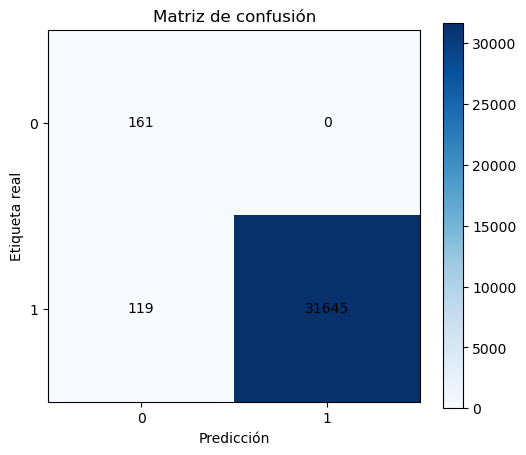

c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall medio (TPR+TNR)/2: 0.9981


In [21]:
matrizConfusion(prediction)
recall_medio = recall_medio_clases(prediction)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")

Vemos unos resultados bastante similares a los anteriores. El recall medio por clases cae ligeramente a 0.9981. Los verdaderos negativos se mantienen igual, han aumentado ligeramente los falsos negativos y descendendido los verdaderos positivos. Por tanto, pese a que las diferencias son super pequeñas. Nos quedamos con la opción de **UNDERSAMPLING**.

Vamos ahora a entrenar varios modelos diferentes con ambos conjuntos de entrenamiento, tanto el train_under como el train_over. Vamos a probar diferentes configuraciones para los modelos con el fin de obtener la mejor de ellas y, tras testearlo con el conjunto de validación, escogeremos el mejor de los modelos para probarlo en nuestro conjunto de test

In [22]:
models = {}

## Regresión Logística

In [23]:
def LR_Pipeline():
    tld_indexer = StringIndexer(
        inputCol="tld",
        outputCol="tld_indexed", 
        handleInvalid="keep"  
    )

    assembler = VectorAssembler(
        inputCols=feature_cols, 
        outputCol="features"
    )

    logistic_regression = LogisticRegression(
        featuresCol='features', 
        labelCol='label'
    )

    pipeline = Pipeline(stages=[tld_indexer, assembler, logistic_regression])

    return pipeline

lr_pipeline = LR_Pipeline()

# Accedemos al stage LogisticRegression
lr_stage = lr_pipeline.getStages()[-1]

paramGrid = (ParamGridBuilder()
    .addGrid(lr_stage.regParam, [0.001, 0.01, 0.1, 1.0])
    .addGrid(lr_stage.elasticNetParam, [0.0, 0.5, 1.0])
    .addGrid(lr_stage.maxIter, [20, 50, 100])
    .build()
)

best_score = float("-inf")
best_model = None
best_params = None
history = []

train_grid, val_grid = train_under.randomSplit([0.8, 0.2], seed=seed)

for i, param in enumerate(paramGrid, start=1):
    print(f"\n[{i}/{len(paramGrid)}] Entrenando con parámetros: {param}")

    model = lr_pipeline.copy(param).fit(train_grid)
    predictions = model.transform(val_grid)

    recall_medio = recall_medio_clases(predictions)
    print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")


    history.append((i, recall_medio, param))

    if recall_medio > best_score:
        best_score = recall_medio
        best_model = model
        best_params = param

print("Entrenamiento modelo final con los mejores parámetros encontrados: ", best_params)
final_model = lr_pipeline.copy(best_params).fit(train_under)
lr_predictions = final_model.transform(val)
recall_medio = recall_medio_clases(lr_predictions)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")
models['Logistic Regression'] = final_model
matrizConfusion(lr_predictions)


[1/36] Entrenando con parámetros: {Param(parent='LogisticRegression_acd936dd6af6', name='regParam', doc='regularization parameter (>= 0).'): 0.001, Param(parent='LogisticRegression_acd936dd6af6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_acd936dd6af6', name='maxIter', doc='max number of iterations (>= 0).'): 20}
Recall medio (TPR+TNR)/2: 1.0000

[2/36] Entrenando con parámetros: {Param(parent='LogisticRegression_acd936dd6af6', name='regParam', doc='regularization parameter (>= 0).'): 0.001, Param(parent='LogisticRegression_acd936dd6af6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_acd936dd6af6', name='maxIter', doc='max number of iterations (>= 0).'): 50}


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

## SVM


[1/12] Entrenando con parámetros: {Param(parent='LinearSVC_dae70547a1d2', name='regParam', doc='regularization parameter (>= 0).'): 0.001, Param(parent='LinearSVC_dae70547a1d2', name='maxIter', doc='max number of iterations (>= 0).'): 20}


/opt/miniconda3/envs/py311ml/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall medio (TPR+TNR)/2: 1.0000

[2/12] Entrenando con parámetros: {Param(parent='LinearSVC_dae70547a1d2', name='regParam', doc='regularization parameter (>= 0).'): 0.001, Param(parent='LinearSVC_dae70547a1d2', name='maxIter', doc='max number of iterations (>= 0).'): 50}
Recall medio (TPR+TNR)/2: 1.0000

[3/12] Entrenando con parámetros: {Param(parent='LinearSVC_dae70547a1d2', name='regParam', doc='regularization parameter (>= 0).'): 0.001, Param(parent='LinearSVC_dae70547a1d2', name='maxIter', doc='max number of iterations (>= 0).'): 100}
Recall medio (TPR+TNR)/2: 1.0000

[4/12] Entrenando con parámetros: {Param(parent='LinearSVC_dae70547a1d2', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(parent='LinearSVC_dae70547a1d2', name='maxIter', doc='max number of iterations (>= 0).'): 20}
Recall medio (TPR+TNR)/2: 1.0000

[5/12] Entrenando con parámetros: {Param(parent='LinearSVC_dae70547a1d2', name='regParam', doc='regularization parameter (>= 0).'): 0.01, Param(par

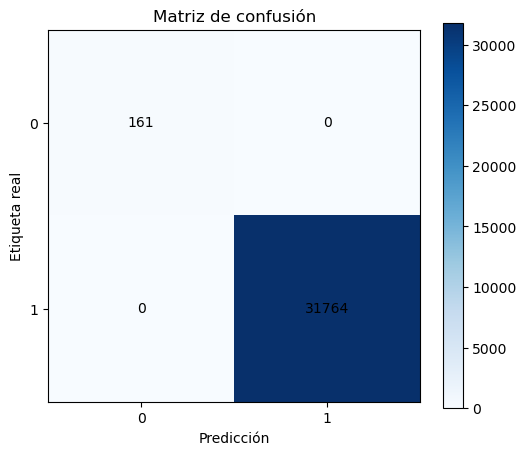

In [ ]:
def SVM_Pipeline():
    tld_indexer = StringIndexer(
        inputCol="tld",
        outputCol="tld_indexed",
        handleInvalid="keep"
    )

    assembler = VectorAssembler(
        inputCols=feature_cols, 
        outputCol="features"
    )
    
    scaler = StandardScaler(
        inputCol="features",
        outputCol="scaledFeatures",
        withMean=True,
        withStd=True
    )

    svm = LinearSVC(
        labelCol="label",
        featuresCol="scaledFeatures",
    )

    svm_pipeline = Pipeline(stages=[
        tld_indexer,
        assembler,
        scaler,
        svm
    ])

    return svm_pipeline


svm_pipeline = SVM_Pipeline()

svm_stage = svm_pipeline.getStages()[-1]

paramGrid = (ParamGridBuilder()
    .addGrid(svm_stage.regParam, [0.001, 0.01, 0.1, 1.0])
    .addGrid(svm_stage.maxIter, [20, 50, 100])
    .build()
)

best_score = float("-inf")
best_model = None
best_params = None
history = []

train_grid, val_grid = train_under.randomSplit([0.8, 0.2], seed=seed)


for i, param in enumerate(paramGrid, start=1):
    print(f"\n[{i}/{len(paramGrid)}] Entrenando con parámetros: {param}")

    model = svm_pipeline.copy(param).fit(train_grid)
    predictions = model.transform(val_grid)

    recall_medio = recall_medio_clases(predictions)
    print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")


    history.append((i, recall_medio, param))

    if recall_medio > best_score:
        best_score = recall_medio
        best_model = model
        best_params = param
        best_train = train

print("\nEntrenamiento modelo final con los mejores parámetros encontrados: ", best_params)
final_model = svm_pipeline.copy(best_params).fit(best_train)
svm_predictions = final_model.transform(val)
models['SVM'] = final_model
recall_medio = recall_medio_clases(svm_predictions)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")
matrizConfusion(svm_predictions)

# Arbol de decisión

In [44]:
feature_cols_dt = [
        'url_length', 'num_dots', 'has_https', 'has_ip', 'num_subdirs',
        'num_params', 'suspicious_words', 'tld_ohe', 'special_char_count',
        'digits_count', 'entropy'
    ]


[1/60] Entrenando con parámetros: {Param(parent='DecisionTreeClassifier_179de5aa8516', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 4, Param(parent='DecisionTreeClassifier_179de5aa8516', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1, Param(parent='DecisionTreeClassifier_179de5aa8516', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 16}
Recall medio (TPR+TNR)/2: 1.0000

[2/60] Entrenando con parámetros: {Param(parent='DecisionTreeClassifier_179de5aa8516', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 lea

Exception ignored in: <function JavaModelWrapper.__del__ at 0x00000239DA3D5300>
Traceback (most recent call last):
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'
Exception ignored in: <function JavaModelWrapper.__del__ at 0x00000239DA3D5300>
Traceback (most recent call last):
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
AttributeError: 'MulticlassMetrics' object has no attribute '_sc'
Exception ignored in: <function JavaModelWrapper.__del__ at 0x00000239DA3D5300>
Traceback (most recent call last):
  File "c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\mllib\common.py", line 152, in __del__
    assert self._sc._gateway is not None
           ^^^^^^^^
Attr

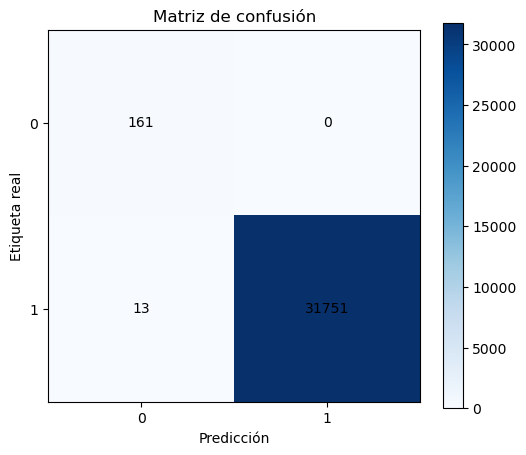

In [36]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml import Pipeline

def arbolDecision_Pipeline():
    tld_indexer = StringIndexer(
        inputCol="tld",
        outputCol="tld_indexed",
        handleInvalid="keep"
    )

    tld_ohe = OneHotEncoder(
        inputCol="tld_indexed",
        outputCol="tld_ohe",
        dropLast=True
    )

    assembler = VectorAssembler(
        inputCols=feature_cols_dt,
        outputCol="features"
    )

    dt_arbol = DecisionTreeClassifier(
        labelCol="label",
        featuresCol="features_scaled"
    )

    return Pipeline(stages=[tld_indexer, tld_ohe, assembler, dt_arbol])


arbol_decision_pipeline = arbolDecision_Pipeline()

dt_stage = arbol_decision_pipeline.getStages()[-1]

paramGrid = (ParamGridBuilder()
    .addGrid(dt_stage.maxDepth, [4, 6, 8, 10, 12])
    .addGrid(dt_stage.minInstancesPerNode, [1, 5, 10, 20])
    .addGrid(dt_stage.maxBins, [16, 32, 64])
    .build()
)

best_score = float("-inf")
best_model = None
best_params = None
history = []

train_grid, val_grid = train_under.randomSplit([0.8, 0.2], seed=seed)


for i, param in enumerate(paramGrid, start=1):
    print(f"\n[{i}/{len(paramGrid)}] Entrenando con parámetros: {param}")

    model = arbol_decision_pipeline.copy(param).fit(train_grid)
    predictions = model.transform(val_grid)

    recall_medio = recall_medio_clases(predictions)
    print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")


    history.append((i, recall_medio, param))

    if recall_medio > best_score:
        best_score = recall_medio
        best_model = model
        best_params = param
        best_train = train

print("\nEntrenamiento modelo final con los mejores parámetros encontrados: ", best_params)
final_model = arbol_decision_pipeline.copy(best_params).fit(best_train)
arbol_predictions = final_model.transform(val)
models['Decision Tree'] = final_model
recall_medio = recall_medio_clases(arbol_predictions)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")
matrizConfusion(arbol_predictions)




# Red Neuronal


[1/90] Entrenando con parámetros: {Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='layers', doc='Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons.'): [11, 8, 2], Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 32}


c:\Users\Ivan1\miniconda3\envs\py311ml\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Recall medio (TPR+TNR)/2: 0.9653

[2/90] Entrenando con parámetros: {Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='layers', doc='Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and output layer of 10 neurons.'): [11, 8, 2], Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='maxIter', doc='max number of iterations (>= 0).'): 10, Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='blockSize', doc='block size for stacking input data in matrices. Data is stacked within partitions. If block size is more than remaining data in a partition then it is adjusted to the size of this data.'): 64}
Recall medio (TPR+TNR)/2: 0.9600

[3/90] Entrenando con parámetros: {Param(parent='MultilayerPerceptronClassifier_7a8c28032783', name='layers', doc='Sizes of layers from input layer to output layer E.g., Array(780, 100, 10) means 780 inputs, one hidden layer with 100 neurons and 

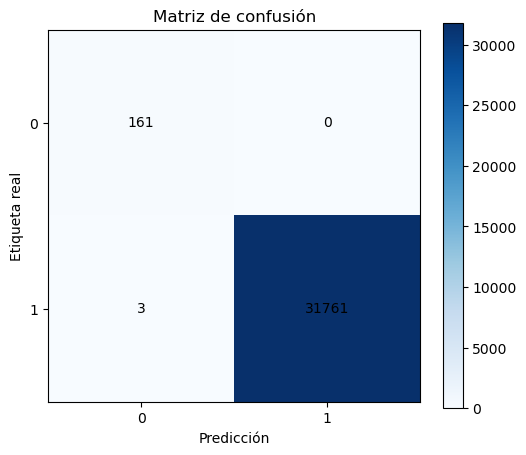

In [ ]:
from pyspark.ml.feature import StringIndexer,  VectorAssembler
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml import Pipeline

def redNeuronal_Pipeline():
    tld_indexer = StringIndexer(
        inputCol="tld",
        outputCol="tld_indexed",
        handleInvalid="keep"
    )

    assembler = VectorAssembler(
        inputCols=feature_cols,
        outputCol="features",
    )

    mpc = MultilayerPerceptronClassifier(
        labelCol="label",
        featuresCol="features",
    ) # luego se meten sus layers

    return Pipeline(stages=[tld_indexer,  assembler, mpc])

red_neuronal_pipeline = redNeuronal_Pipeline()

mpc_stage = red_neuronal_pipeline.getStages()[-1]

feature_nums = len(feature_cols)
class_numm = 2
paramGrid = (ParamGridBuilder()
    .addGrid(mpc_stage.layers, [[feature_nums, 8 , class_numm],
                                [feature_nums, 16 , class_numm],
                                [feature_nums, 32 , class_numm],
                                [feature_nums, 64 , class_numm],
                                [feature_nums, 32, 16 , class_numm],
                                [feature_nums, 64, 32 , class_numm]])
    .addGrid(mpc_stage.maxIter, [10, 25, 50, 100, 200])
    .addGrid(mpc_stage.blockSize, [ 32, 64, 128])
    .build()
)

best_score = float("-inf")
best_model = None
best_params = None
history = []

train_grid, val_grid = train_under.randomSplit([0.8, 0.2], seed=seed)

for i, param in enumerate(paramGrid, start=1):
    print(f"\n[{i}/{len(paramGrid)}] Entrenando con parámetros: {param}")

    model = red_neuronal_pipeline.copy(param).fit(train_grid)
    predictions = model.transform(val_grid)
    
    recall_medio = recall_medio_clases(predictions)
    print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")

    history.append((i, recall_medio, param))

    if recall_medio > best_score:
        best_score = recall_medio
        best_model = model
        best_params = param
        best_train = train

print("\nEntrenamiento modelo final con los mejores parámetros encontrados: ", best_params)
final_model = red_neuronal_pipeline.copy(best_params).fit(best_train)
arbol_predictions = final_model.transform(val)
models['Multilayer Perceptron'] = final_model
recall_medio = recall_medio_clases(arbol_predictions)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")
matrizConfusion(arbol_predictions)

# mas de 33 minutos


Vamos a quedarnos ahora con el mejor modelo 

/opt/miniconda3/envs/py311ml/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Resultados para el modelo: Logistic Regression


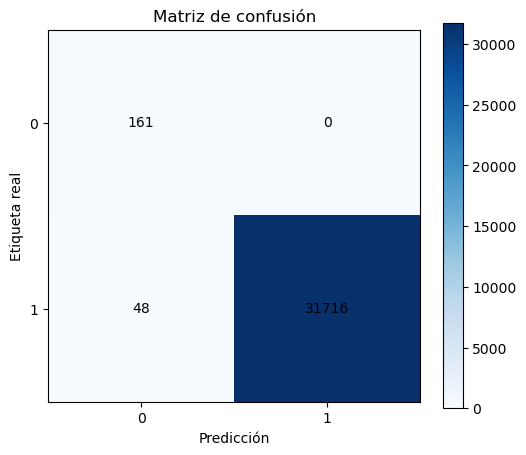

/opt/miniconda3/envs/py311ml/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Resultados para el modelo: SVM


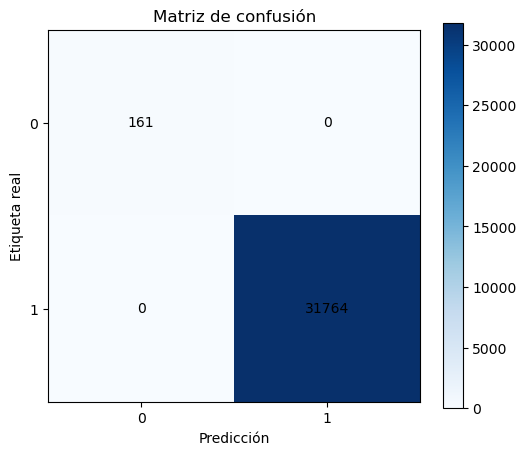

/opt/miniconda3/envs/py311ml/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Resultados para el modelo: Decision Tree


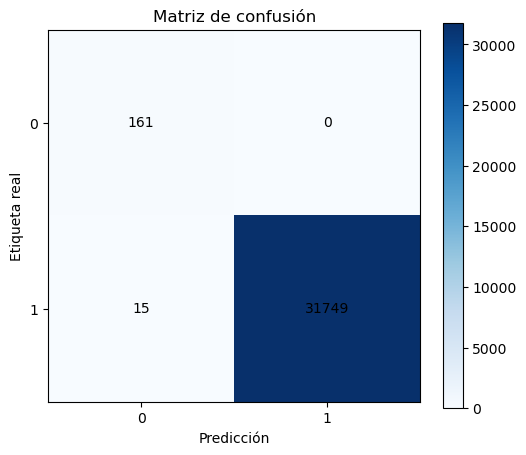

El mejor modelo es: SVM


In [ ]:
best_score = float("-inf")
best_model_name = None
best_model = None
for name, model in models.items():
    model_prediction = model.transform(val)
    if (recall_medio_clases(model_prediction) >= best_score):
        best_model_name = name
        best_model = model
        best_score = recall_medio_clases(model_prediction)
    print(f"\nResultados para el modelo: {name}")
    matrizConfusion(model_prediction)

print("El mejor modelo es:", best_model_name)

## Resultados finales

Recall medio (TPR+TNR)/2: 1.0000


/opt/miniconda3/envs/py311ml/lib/python3.11/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


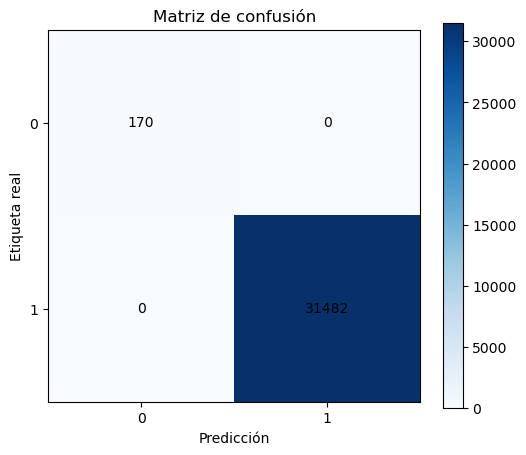

In [ ]:
final_prediction = best_model.transform(test)
recall_medio = recall_medio_clases(final_prediction)
print(f"Recall medio (TPR+TNR)/2: {recall_medio:.4f}")
matrizConfusion(final_prediction)

Obtenemos un recall medio por clases total de 1. Nuestro modelo final, clasifica a la perfección todos los ejemplos que están incluídos en nuestro dataset. Esto se puede deber a dos cosas:
- Hemos hecho un trabajo perfecto y nuestros modelos son infalibles (poco probable)
- Nuestro dataset está especialmente diseñado para pruebas académicas y por eso nos sale un resultado tan perfecto.

Al haber pocos ejemplos de urls que no sean phising, no podemos asegurar que todas vayan a ser clasificadas de forma correcta. Habría que tener un base de datos un poco más balanceada ya por defecto y testearla con ella para ver el rendimiento de nuestro modelo

Genera el vector de features del dataset a partir de una URL nueva.

In [ ]:
from __future__ import annotations

from dataclasses import asdict, dataclass
from typing import Iterable, Optional, Dict, Any, List
from urllib.parse import urlparse, parse_qsl
import ipaddress
import math
from collections import Counter

try:
    import tldextract
except ImportError:
    tldextract = None


DEFAULT_SUSPICIOUS_KEYWORDS = [
    "login",
    "verify",
    "secure",
    "account",
    "update",
    "signin",
    "bank",
    "confirm",
    "password",
    "webscr",
    "billing",
    "support",
    "security",
    "paypal",
    "appleid",
    "microsoft",
    "invoice",
    "limited",
    "unlock",
]

SPECIAL_CHARS_SET = set("-_%@=~")  # según tu descripción


def _ensure_scheme(url: str) -> str:
    """Si viene sin esquema, asumimos http:// para que urlparse funcione bien."""
    u = url.strip()
    if not u:
        return u
    if "://" not in u:
        return "http://" + u
    return u


def shannon_entropy(s: str) -> float:
    """Entropía Shannon sobre caracteres."""
    if not s:
        return 0.0
    counts = Counter(s)
    n = len(s)
    ent = 0.0
    for c in counts.values():
        p = c / n
        ent -= p * math.log2(p)
    return ent


def extract_tld(hostname: Optional[str]) -> str:
    """Extrae el TLD (ej: com, ru, icu). Si no hay hostname, devuelve ''."""
    if not hostname:
        return ""

    h = hostname.strip().lower().strip(".")
    if not h:
        return ""

    # Si tenemos tldextract, usar snapshot local (sin intentar bajar listas).
    if tldextract is not None:
        ext = tldextract.TLDExtract(suffix_list_urls=None)  # evita downloads
        res = ext(h)
        return res.suffix.split(".")[-1] if res.suffix else ""

    # Fallback simple: último segmento
    parts = h.split(".")
    return parts[-1] if len(parts) >= 2 else ""


def is_ip_host(hostname: Optional[str]) -> int:
    if not hostname:
        return 0
    try:
        ipaddress.ip_address(hostname)
        return 1
    except ValueError:
        return 0


def suspicious_words_count(
    url: str, keywords: Iterable[str], mode: str = "unique"
) -> int:
    """
    mode:
      - "unique": cuenta cuántas keywords aparecen al menos una vez
      - "total": suma ocurrencias (url.count(keyword))
    """
    u = url.lower()
    kws = [k.lower() for k in keywords]

    if mode == "total":
        return sum(u.count(k) for k in kws if k)
    # unique
    return sum(1 for k in kws if k and (k in u))


@dataclass
class URLFeatures:
    url: str
    url_length: int
    num_dots: int
    has_https: int
    has_ip: int
    num_subdirs: int
    num_params: int
    suspicious_words: int
    tld: str
    special_char_count: int
    digits_count: int
    entropy: float
    isPhishing: int


def compute_url_features(
    url: str,
    suspicious_keywords: Optional[Iterable[str]] = None,
    suspicious_mode: str = "unique",
    special_chars: Optional[Iterable[str]] = None,
    isPhishing: int = 0,
) -> Dict[str, Any]:
    """
    Devuelve un dict con features similares a tu dataset (sin 'label').

    suspicious_mode: "unique" o "total"
    """
    suspicious_keywords = suspicious_keywords or DEFAULT_SUSPICIOUS_KEYWORDS
    special_chars_set = (
        set(special_chars) if special_chars is not None else SPECIAL_CHARS_SET
    )

    normalized = _ensure_scheme(url)
    parsed = urlparse(normalized)

    hostname = parsed.hostname  # ya viene sin puerto y en lower en la mayoría de casos
    has_https = 1 if parsed.scheme.lower() == "https" else 0

    # subdirs: cantidad de "/" en el path (no incluye "https://")
    num_subdirs = url.count("/")

    # params: cantidad real de parámetros en query (k=v). Si quieres solo contar & + ?,
    # puedes cambiar esto por: 0 if not parsed.query else parsed.query.count("&") + 1
    num_params = (
        len(parse_qsl(parsed.query, keep_blank_values=True)) if parsed.query else 0
    )

    feats = URLFeatures(
        url=url,
        url_length=len(url),
        num_dots=url.count("."),
        has_https=has_https,
        has_ip=is_ip_host(hostname),
        num_subdirs=num_subdirs,
        num_params=num_params,
        suspicious_words=suspicious_words_count(
            url, suspicious_keywords, mode=suspicious_mode
        ),
        tld=extract_tld(hostname),
        special_char_count=sum(1 for ch in url if ch in special_chars_set),
        digits_count=sum(1 for ch in url if ch.isdigit()),
        entropy=shannon_entropy(url),
        isPhishing=isPhishing,
    )

    return asdict(feats)


# ---- ejemplo rápido ----
if __name__ == "__main__":
    test = "http://forum.uk.securebankinggroup.com/107519/8af662/475d964a-0243-46bf-aefd-66da26254efa"
    print(compute_url_features(test, isPhishing=1))


{'url': 'http://forum.uk.securebankinggroup.com/107519/8af662/475d964a-0243-46bf-aefd-66da26254efa', 'url_length': 89, 'num_dots': 3, 'has_https': 0, 'has_ip': 0, 'num_subdirs': 5, 'num_params': 0, 'suspicious_words': 2, 'tld': 'com', 'special_char_count': 4, 'digits_count': 29, 'entropy': 4.792984909698331, 'isPhishing': 1}
